In [158]:
import os
import time
import subprocess
import math
import fileinput
import sys
from astropy.io import fits 
import numpy as np
import matplotlib.pyplot as plt
import re
from dateutil.parser import parse
import datetime
from scipy.optimize import curve_fit
from scipy import ndimage

import ana_connie_lib as ana

# '''

# import scipy.ndimage as ndimage
# import glob
# import copy
# import pandas as pd
# import os

# from scipy import optimize
# from dateutil.parser import parse
# from scipy.stats import poisson, norm

# from scipy.signal import find_peaks
# from matplotlib import colors
# import re
# import argparse
# import sys
# import warnings
# import skimage.measure as sk
# from scipy.optimize import OptimizeWarning
# warnings.simplefilter("error", OptimizeWarning) # If the fit are not good get an error
# warnings.simplefilter("error", RuntimeWarning) # for overflow in exponentials and ivalid values get an error
# '''

In [159]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    }) 

# Convert the MCM.fz to MCM with 16 channels
Code based on one_mcm_256chToolV4_reverse_os.py

In [160]:
filePath='/home/oem/datosFits/mcm_data/ansamp/'
#fileName='mcm029_test__ANSAMP25_full_34.fz'
fileName='barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP300_26.fz'
#fileName='barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP100_24.fz'
h=fits.open(filePath+fileName)
h.info()
#Get some header values
ANSAMP=int(h[1].header['ANSAMP'])
NCOL=int(h[1].header['NCOL'])
print(ANSAMP,NCOL)
dictPo={}

Filename: /home/oem/datosFits/mcm_data/ansamp/barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP300_26.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    165   (19200, 100)   int32   
  2  COMPRESSED_IMAGE    1 CompImageHDU    164   (19200, 100)   int32   
  3  COMPRESSED_IMAGE    1 CompImageHDU    164   (19200, 100)   int32   
  4  COMPRESSED_IMAGE    1 CompImageHDU    164   (19200, 100)   int32   
300 1200


In [161]:
#Channel mapping between MCM and Mux in the front-end==============================================================
#MCM=>FLEX=>idb=>Front end electronics
# 1  5  9 13
# 2  6 10 14 => to MCM flex
# 3  7 11 15 => to MCM flex
# 4  8 12 16
MappingToMux=[8,7,6,16,15,14,13,12,11,10,9,5,4,3,2,1] #SENSEICOPY Mapping from MCM positions to MUX inputs.CCD1=>Mux S8, CCD2=>Mux S7, CCD3=>Mux S6,...CCD16=>Mux S1 
#MappingToMux=[1,3,2,4,5,9,10,11,12,13,14,15,16,7,6,8];  #Old mapping with idb and 50 pins front end:
MappingToOHDUinfits=[1,5,9,13,2,6,10,14,3,7,11,15,4,8,12,16] #Mapping from Mux inputs to OHDU positions in fits file
#==================================================================================================================

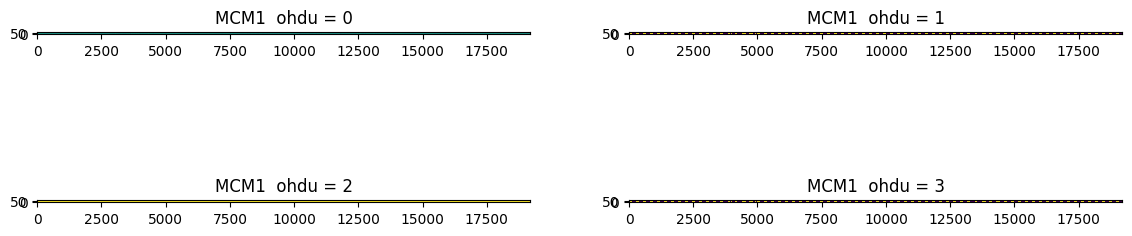

In [162]:
plt.figure(figsize=(14,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(h[i+1].data[:,:]-np.median(h[i+1].data), vmin=-10, vmax=10)
    plt.title('MCM1  ohdu = {:d}'.format(i))
#plt.savefig('BeforeXTALK.png', bbox_inches='tight', dpi=100)

In [163]:
hduUse=2  # arbitrary indicated by Claudio.  4 also has signal but we will not use it for analysis
print("the hdu with signal is: ",hduUse)


the hdu with signal is:  2


In [164]:
#output file name
MCMNro=1
outname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)+'.fits';
print(outname)
pdfname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)

MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP300_26.fits


In [165]:
step=16
#Get 16-demuxed Images from the MCM
#Primary HDU no data, only main header
Primaryhdu_MCM = fits.PrimaryHDU() # Create primary HDU without data
hdu_list_MCM = fits.HDUList([Primaryhdu_MCM]) #Create HDU list
hdu_list_MCM[0].header=h[0].header
for i in range(0,16):
	MapMCM_ColInit=MappingToMux[MappingToOHDUinfits[i]-1]  #REVISAR ACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaaa!
	datai=np.int32(ana.GetSingleCCDImage(h,hduUse,MapMCM_ColInit,NCOL,step,1))
	#print(datai.dtype)
	image_hdu=fits.ImageHDU(datai);
	image_hdu.header=h[hduUse].header #Repear the header of the used hdu channel into all the 16-channles
	image_hdu.header.set('NSAMP',ANSAMP)
	hdu_list_MCM.append(image_hdu)

In [166]:
h[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [167]:
h[hduUse].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1200 / length of data axis 1                          
NAXIS2  =                  100 / length of data axis 2                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ANSAMP  = '300     '           / Smart sequencer variable                       
CCDNCOL = '2216    '           / Smart sequencer variable                       
CCDNPRES= '7       '           / Smart sequencer variable                       
CCDNROW = '2556    '           / Smart sequencer variable                       
NCOL    = '1200    '           / Smart sequencer variable                       
NCOL1   = '1107    '        

In [168]:
#imprime el Header para verlo en un archivo de texto  # 15 Feb
fileHeader=open('fileHeader.txt', 'w')
fileHeader.write(repr(h[1].header))
fileHeader.close()


In [169]:
#save demux file
hdu_list_MCM.writeto(outname,overwrite=True);
hdu_list_MCM.close()

In [170]:
hm = hdu_list_MCM
hmb = hdu_list_MCM

print(hm.info())
#print(hm[1].header)

# Some infos hmb = hdu_list_MCMfrom the header:
CCDNROW = hm[1].header["CCDNROW"]
CCDNCOL = hm[1].header["CCDNCOL"]
NROW = hm[1].header["NROW"]
NCOL = hm[1].header["NCOL"]
NSAMP = hm[1].header["NSAMP"]
# MCMs/
ANSAMP = hm[1].header["ANSAMP"]

print("CCDNROW = ", CCDNROW, " - CCDNCOL = ", CCDNCOL, " - NROW = ", NROW, " - NCOL = ", NCOL, " - ANSAMP = ", NSAMP)


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 ImageHDU       164   (1200, 100)   int32   
  2                1 ImageHDU       164   (1200, 100)   int32   
  3                1 ImageHDU       164   (1200, 100)   int32   
  4                1 ImageHDU       164   (1200, 100)   int32   
  5                1 ImageHDU       164   (1200, 100)   int32   
  6                1 ImageHDU       164   (1200, 100)   int32   
  7                1 ImageHDU       164   (1200, 100)   int32   
  8                1 ImageHDU       164   (1200, 100)   int32   
  9                1 ImageHDU       164   (1200, 100)   int32   
 10                1 ImageHDU       164   (1200, 100)   int32   
 11                1 ImageHDU       164   (1200, 100)   int32   
 12                1 ImageHDU       164   (1200, 100)   int32   
 13                1 ImageHDU       164   (1200, 100)   in

(array([1.560e+02, 1.650e+03, 4.558e+03, 7.478e+03, 9.092e+03, 9.030e+03,
        8.723e+03, 8.492e+03, 8.691e+03, 8.640e+03, 8.409e+03, 7.472e+03,
        6.249e+03, 5.010e+03, 3.633e+03, 2.564e+03, 1.629e+03, 1.032e+03,
        5.740e+02, 3.000e+02, 1.690e+02, 1.040e+02, 4.800e+01, 4.000e+01,
        3.900e+01, 2.300e+01, 2.500e+01, 1.900e+01, 7.000e+00, 1.100e+01,
        4.000e+00, 9.000e+00, 6.000e+00, 8.000e+00, 6.000e+00, 6.000e+00,
        1.400e+01, 7.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 6.000e+00,
        5.000e+00, 4.000e+00, 6.000e+00, 6.000e+00, 7.000e+00, 5.000e+00,
        7.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 4.000e+00,
        6.000e+00, 5.000e+00, 2.000e+00, 5.000e+00, 5.000e+00, 6.000e+00,
        1.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 5.000e+00, 8.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        4.000e+00, 4.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        6.000e+00, 1.000e+00, 0.000e+0

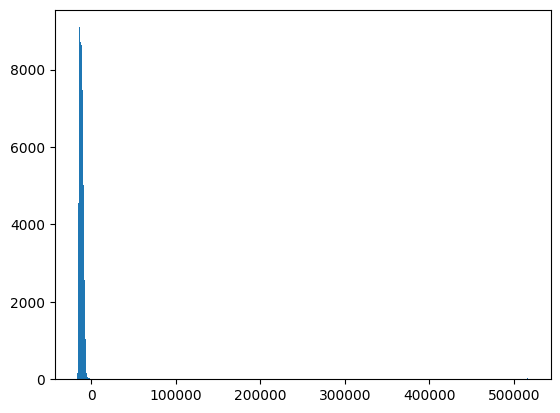

In [173]:
nCCDs=16

# define active and overscan masks
active_mask = np.s_[:, 10:1057] # 
overscan_mask = np.s_[:, -91:-1] 
plt.hist(hm[3].data[active_mask].flatten(),bins=1000)

In [172]:
nCCDs=16f

# define active and overscan masks
active_mask = np.s_[:, 10:1057] # 
overscan_mask = np.s_[:, -91:-1] 

plt.figure(figsize=(24,8))
for i in range(nCCDs):
    plt.subplot(4,4,i+1)
    plt.imshow(hm[i+1].data[:,:]-np.median(hm[i+1].data), vmin=-50, vmax=50)
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))

SyntaxError: invalid decimal literal (2001949399.py, line 1)

In [ ]:
# header info
#print(hm[1].header["DATEEND"],hm[1].header["DATESTART"])
start = parse(hm[1].header["DATESTART"]+"Z").timestamp()
end = parse(hm[1].header["DATEEND"]+"Z").timestamp()
deltatime = datetime.timedelta(seconds=end-start)
readout_time = deltatime.total_seconds()
print("Readout time = ", readout_time, "s")
print("               ", round(readout_time/3600,2), "h")
print("               ", round(readout_time/86400,3), "days")

Readout time =  63.0 s
                0.02 h
                0.001 days


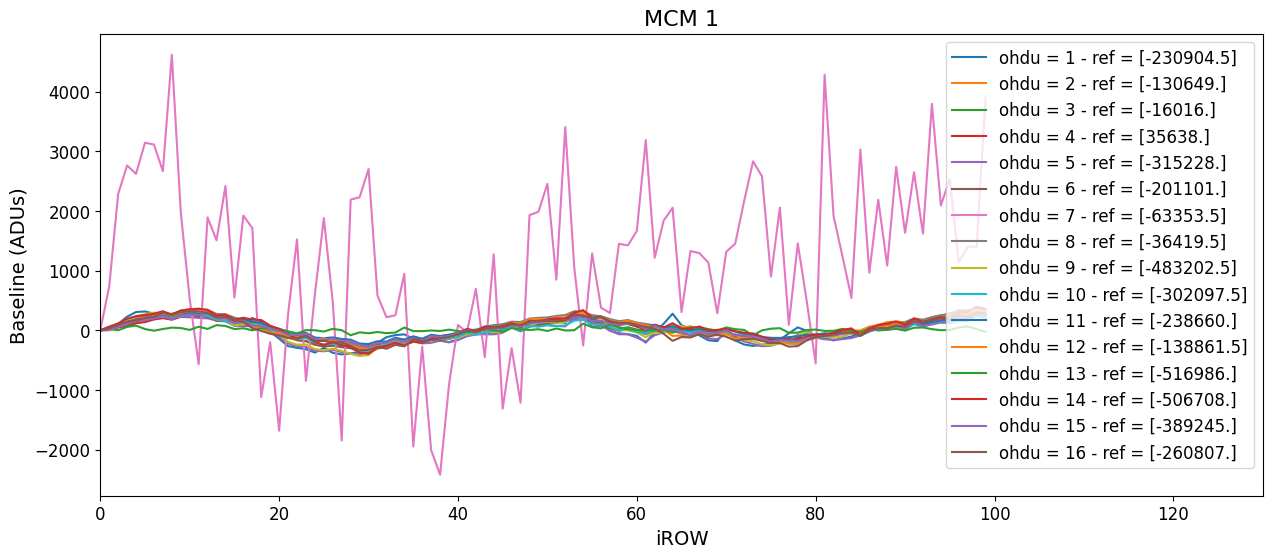

In [174]:
doPlot=1
# made the baseline plot and print the baseline diffetences
baseline = ana.Baseline(hm, overscan_mask, MCMNro, nCCDs, doPlot, pdfname)  #Evolucion del Base Line
#

In [175]:
hmb = np.copy(hm)                   #se sobre escribe el dato, 
for i in range(nCCDs):      #el valor de la imagen sera el de la imagen cruda menos la mediana
    hmb[i+1].data = (hm[i+1].data.astype('float64') - np.median(hm[i+1].data[active_mask], axis=1, keepdims=True))/int(ANSAMP)
    


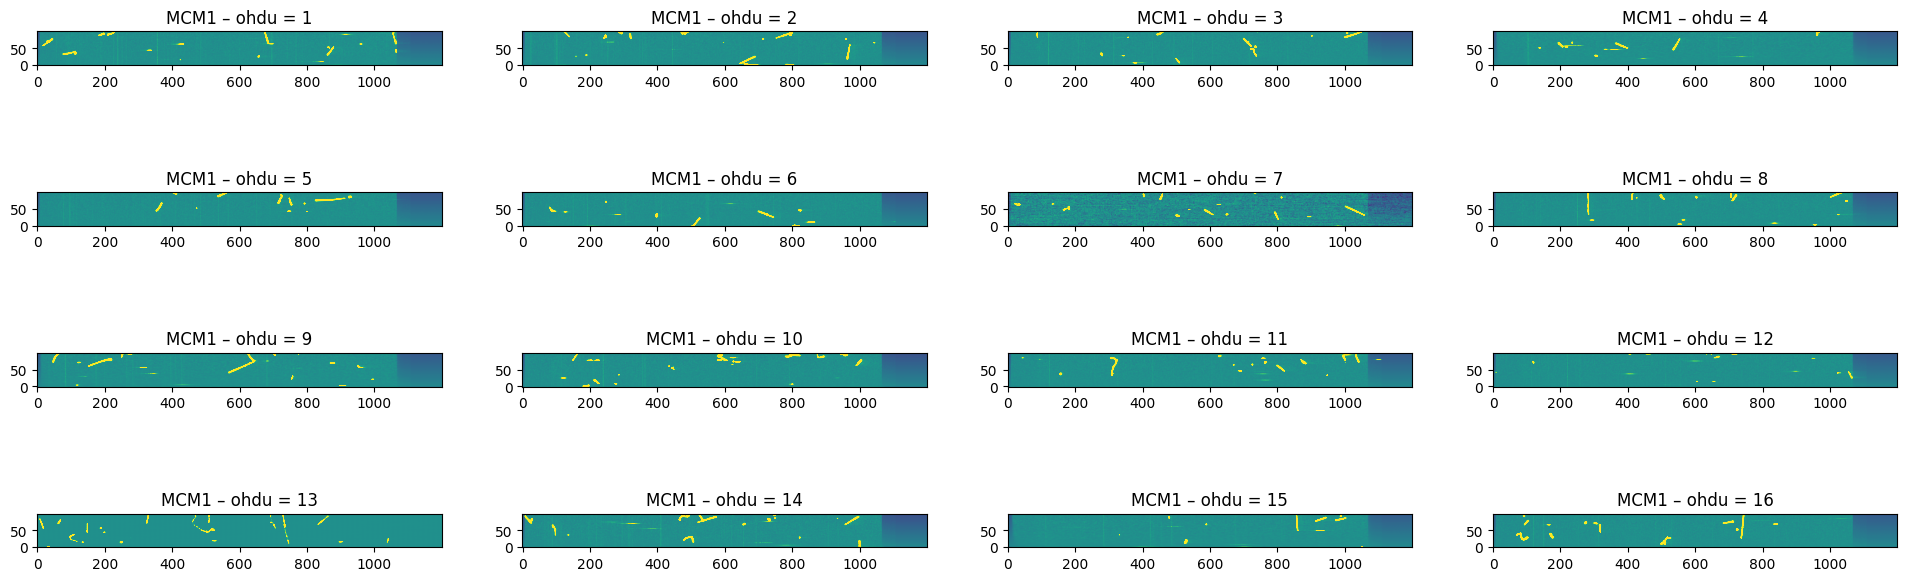

In [176]:
plt.figure(figsize=(24,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(hmb[i+1].data, vmin=-50, vmax=50)    #Plot de cada imagen en un rango de -500 a 500 ADUS
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))

In [ ]:
ohdusOK = np.zeros((16,), dtype=int)
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)             #para que es este Histograma, que se ve aqui????
    y, x, _ = plt.hist(hmb[i+1].data[active_mask].flatten(),100,density=True, histtype='step', cumulative=True)
    print(i,x.max())
    if x.max()>100: ohdusOK[i]=1
plt.close()
print(ohdusOK)

#y, x, _ = plt.hist(hmb[1].data[active_mask].flatten(),100,density=True, histtype='step', cumulative=True)

0 65.0
1 1084.0
2 3531.0
3 2643.0
4 3143.0
5 5208.0
6 771.0
7 55.0
8 2509.0
9 4807.0
10 2362.0
11 227.0
12 56.0
13 68.0
14 4309.0
15 1259.0
[0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1]


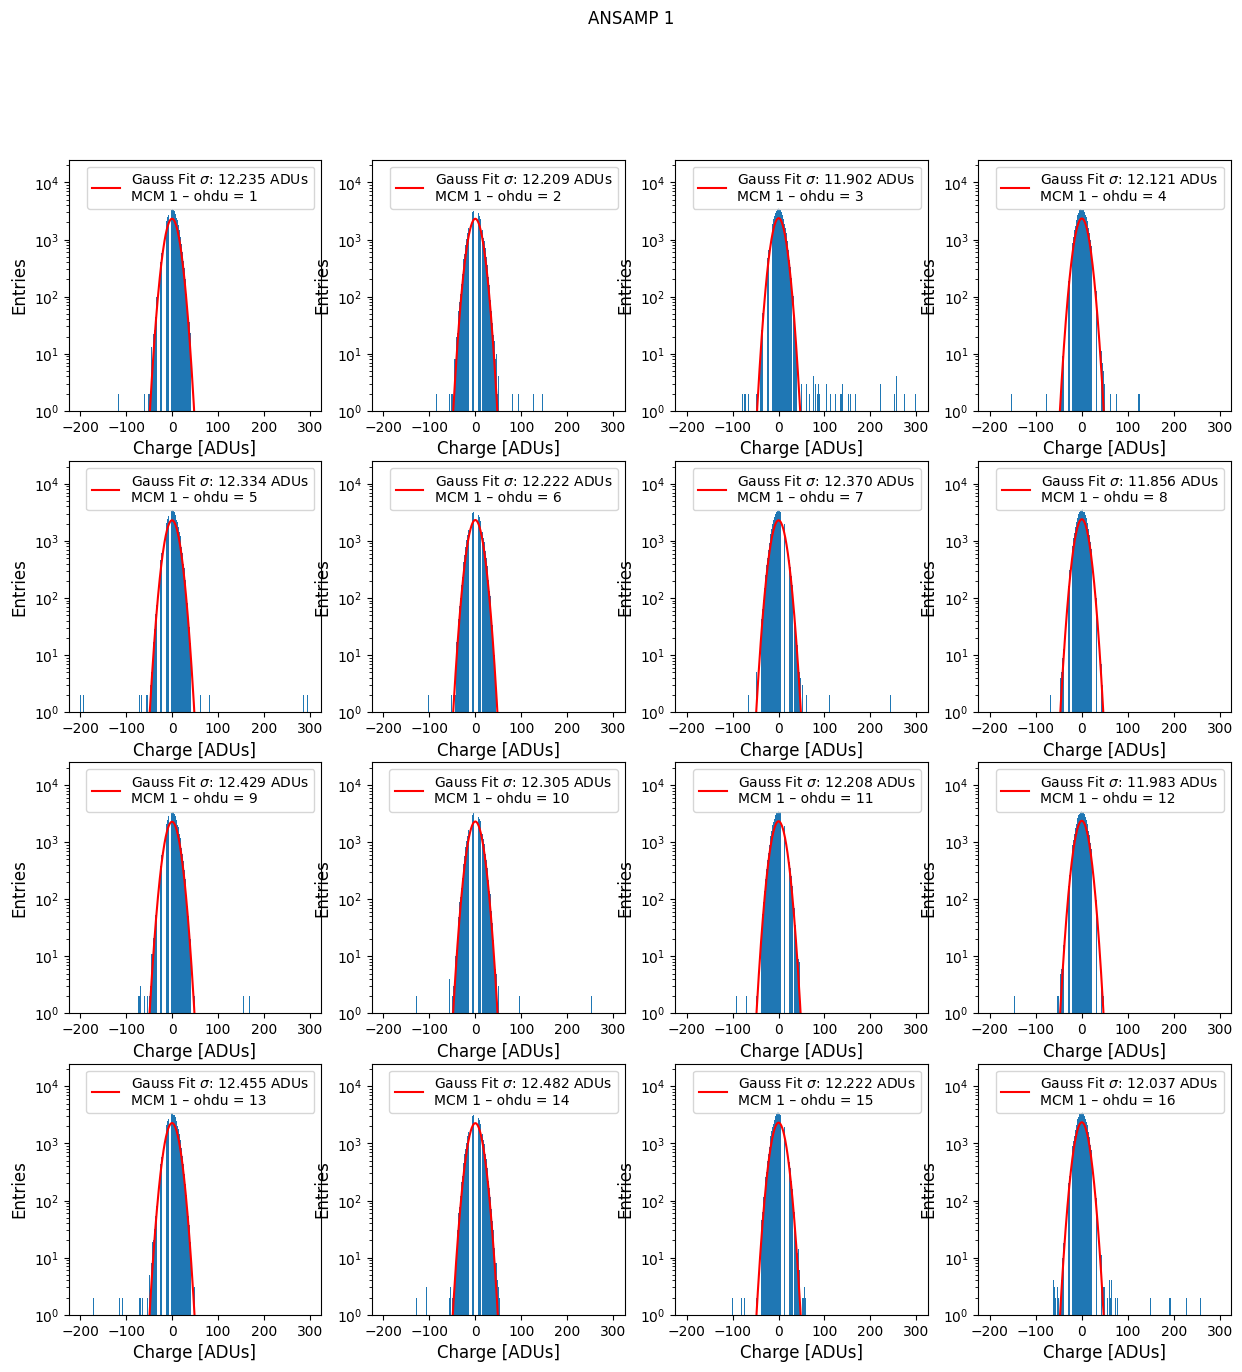

In [ ]:
# Noise
#noise = Noise(hmb, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot, pdfname)
noise=ana.Noise(hmb, active_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='None.pdf')


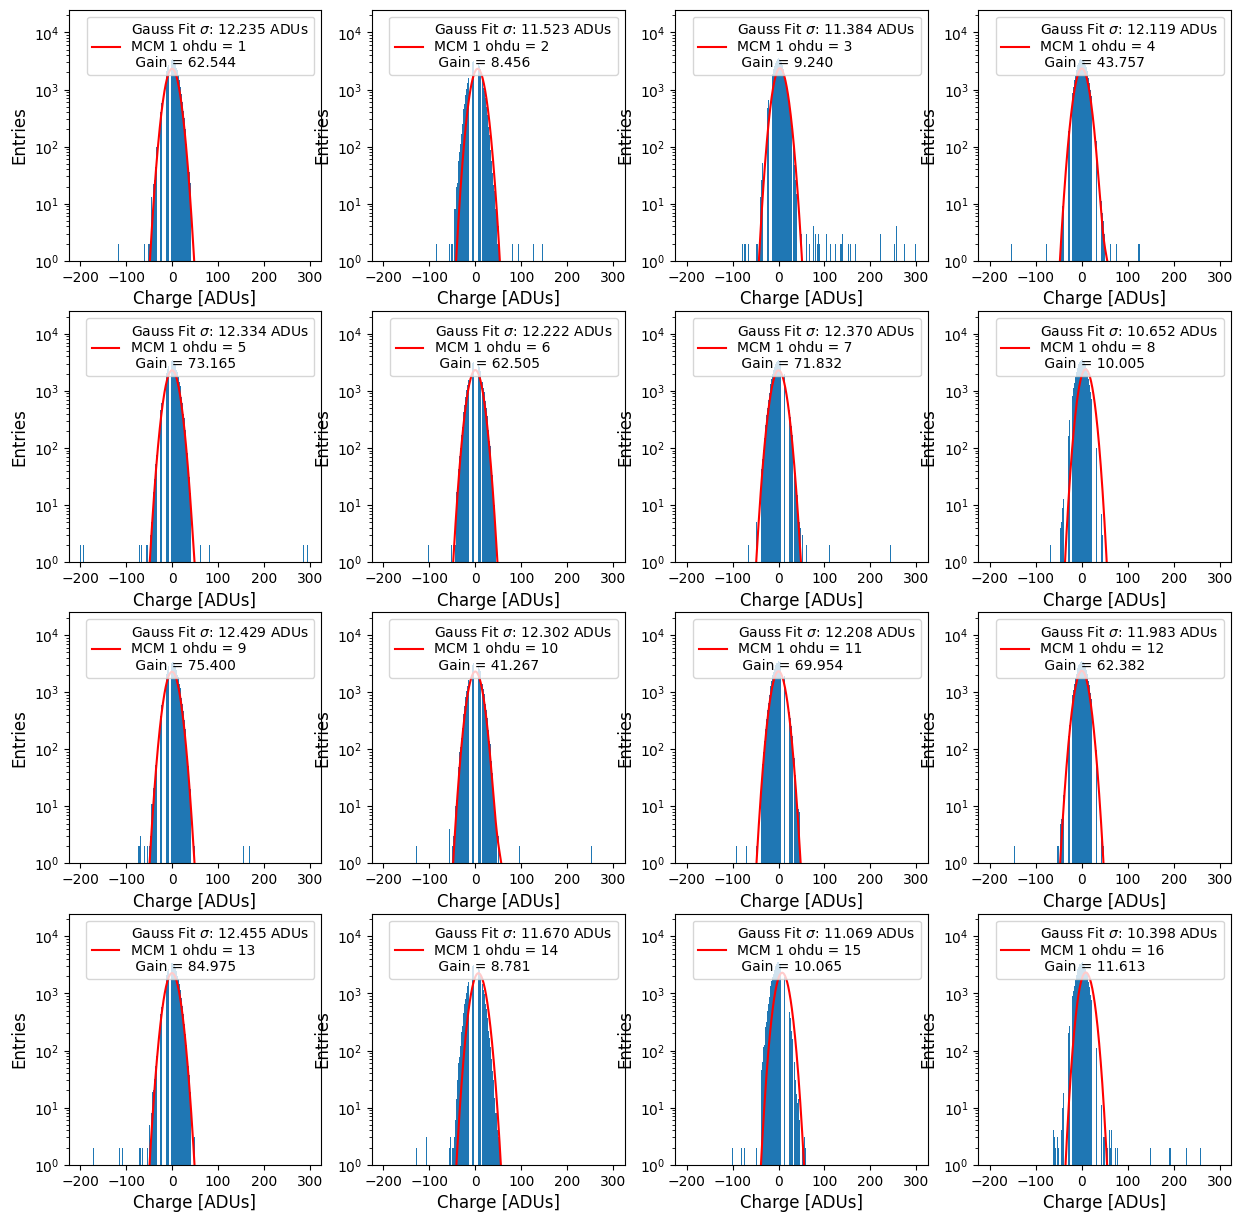

[12.234878397490485,
 11.522813970119746,
 11.383520838333139,
 12.118860476790754,
 12.333947601254055,
 12.222066560651717,
 12.369540135837806,
 10.652076409853056,
 12.429244876558833,
 12.301531783688402,
 12.207679472942285,
 11.982612224141041,
 12.455085282407513,
 11.669760879228326,
 11.068639952646045,
 10.39824448182283]

In [ ]:
# Gain
ana.Gain(hmb, active_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='None.pdf')


### En esta imagen existe un offset entre el area activa y el overscan, es necesario generar una mediana del area activa

array([-2.30904031e+05,  4.88105200e+00,  5.53866298e+04,  4.51666476e+01,
        4.23700182e+02])

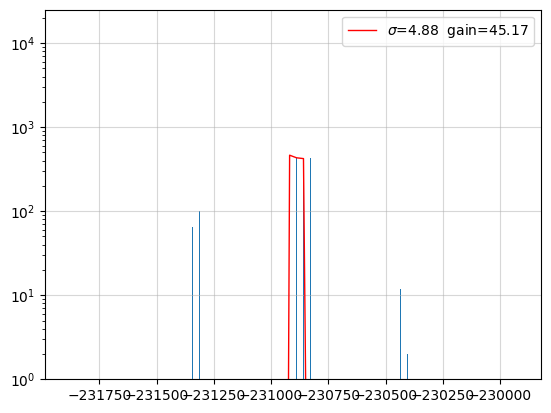

In [ ]:
x=np.median(hm[1].data[overscan_mask])
ana.histoFit(hm,1,overscan_mask, range=(np.mean(hm[1].data[overscan_mask])-1000,np.mean(hm[1].data[overscan_mask])+1000),porDefecto=[x,3,1500, 44, 100] )

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  3.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,
         0.,  2.,  0.,  1.,  2.,  0.,  3.,  0.,  0.,  0.,  2.,  4.,  0.,
         0.,  0.,  1.,  2.,  2.,  0.,  1.,  2.,  0.,  3.,  1.,  1.,  3.,
         1.,  1.,  0.,  1.,  0.,  0.,  6.,  3.,  0.,  3.,  2.,  2.,  0.,
         2.,  1.,  2.,  2.,  4.,  3.,  1.,  0.,  2.,  2.,  1.,  2.,  7.,
         2.,  2.,  3.,  0.,  4.,  6.,  0.,  3.,  2.,  2.,  5.,  0.,  2.,
         0.,  3.,  3.,  0.,  3.,  3.,  0.,  3.,  3.,  4.,  3.,  1.,  3.,
         4.,  5.,  0.,  1.,  4.,  1.,  0.,  3.,  2.,  4.,  0.,  6.,  3.,
         2.,  2.,  5.,  6.,  3.,  0.,  4.,  3.,  5.

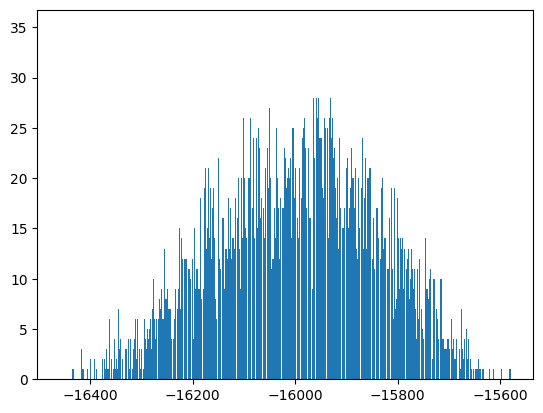

In [ ]:
plt.hist(hm[3].data[overscan_mask].flatten(),bins=1000)

# Abriendo Nuevo archivo

In [ ]:
with fits.open('/home/oem/datosFits/mcm_data/ansamp/MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP10_19.fits') as fileFits:
    fileFits.info()
  

Filename: /home/oem/datosFits/mcm_data/ansamp/MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP10_19.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 ImageHDU       164   (1200, 100)   int32   
  2                1 ImageHDU       164   (1200, 100)   int32   
  3                1 ImageHDU       164   (1200, 100)   int32   
  4                1 ImageHDU       164   (1200, 100)   int32   
  5                1 ImageHDU       164   (1200, 100)   int32   
  6                1 ImageHDU       164   (1200, 100)   int32   
  7                1 ImageHDU       164   (1200, 100)   int32   
  8                1 ImageHDU       164   (1200, 100)   int32   
  9                1 ImageHDU       164   (1200, 100)   int32   
 10                1 ImageHDU       164   (1200, 100)   int32   
 11                1 ImageHDU       164   (1200, 100)   int32   
 12                1 ImageHDU       164   (1200, 100) 

### Observamos que existe una tendencia al igiual que en la imagen anterior

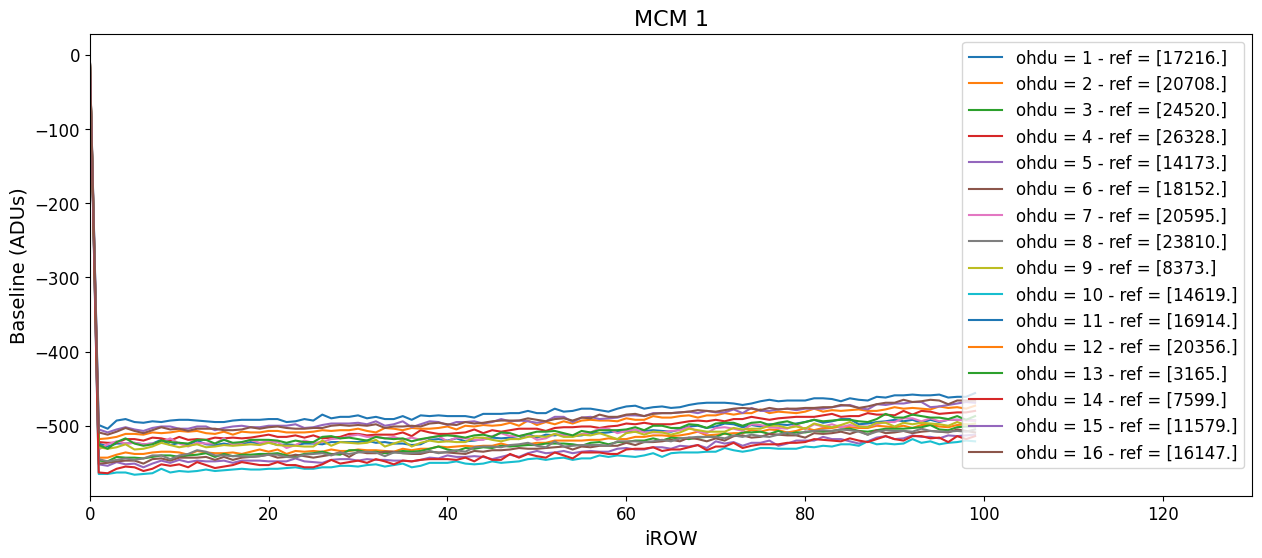

In [ ]:
#np.median(fileFits[1].data)
#ana.histoFit(fileFits,1,active_mask,range=(24750,25250),porDefecto=[24900,15,1500, 50, 100])
# with fits.open('/home/oem/datosFits/mcm_data/ansamp/MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP10_19.fits') as fileFits:
#     mediana=ana.Baseline(fileFits, active_mask, 1, nCCDs, doPlot=True,pdfname='None.pdf')
#     dataCopy=np.copy(fileFits)


# Base line sustracted
### Existe una tendencia que hay que eliminar, sustrayendo la mediana por renglon a toda la imagen

In [ ]:



#Luego vemos como usar with ope 
# with fits.open('/home/oem/datosFits/mcm_data/ansamp/MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP10_19.fits') as fileFits:
#     dataFits=fileFits.readall()

# x=np.median(dataCopy[1].data[active_mask])
# ana.histoFit(dataCopy,1,active_mask, range=(x-100,x+100),porDefecto=[x,3,1500, 44, 100] ) #data, sigma, Magnitud_1, Gain expected, Magnitud_2



Pedimos que se reste la mediana de cada 

In [ ]:
# len(mediana[0]) # len(mediana[ext])= 100, hay que buscar restarle la mediana por renglon a la imagen
fileFits=fits.open('/home/oem/datosFits/mcm_data/ansamp/MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP10_19.fits')
dataCopy[1].data=(fileFits[1].data-np.median(fileFits[1].data[active_mask]))/(int(fileFits[1].header['ANSAMP']))

In [ ]:
x=np.median(dataCopy[1].data[active_mask])
popt=ana.histoFit(dataCopy,1,active_mask, range=(-100,+100),porDefecto=[x,3,1500, 44, 100] ) #data, sigma, Magnitud_1, Gain expected, Magnitud_2

ValueError: I/O operation on closed file

In [ ]:
for ext in range(1, len(fileFits)):
    dataCopy[ext].data=(fileFits[ext].data-np.median(fileFits[ext].data[active_mask]))/(int(fileFits[1].header['ANSAMP']))

In [ ]:
#noise=ana.Noise(hmb, active_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='None.pdf')
stop
Noise_list=ana.Noise(dataCopy, active_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='noise.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error - gain fit failednoise.pdf


In [ ]:
path_files='/home/oem/datosFits/mcm_data/ansamp'
listFiles=os. listdir(path_files) 
numberList = []
dict_list = {}
for i in listFiles:
    dict_list[(i.split('_')[-1]).split('.')[0]]=i

order2process=sorted(dict_list)

for i in order2process:
    fileName=dict_list[i].split('.')[0]
    MCMNro=1
    outname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)+'.fits';
    step=16
    #Get 16-demuxed Images from the MCM
    #Primary HDU no data, only main header
    Primaryhdu_MCM = fits.PrimaryHDU() # Create primary HDU without data
    hdu_list_MCM = fits.HDUList([Primaryhdu_MCM]) #Create HDU list
    hdu_list_MCM[0].header=h[0].header
    for i in range(0,16):
        MapMCM_ColInit=MappingToMux[MappingToOHDUinfits[i]-1]  #REVISAR ACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaaa!
        datai=np.int32(GetSingleCCDImage(h,hduUse,MapMCM_ColInit,NCOL,step,1))
        #print(datai.dtype)
        image_hdu=fits.ImageHDU(datai);
        image_hdu.header=h[hduUse].header #Repear the header of the used hdu channel into all the 16-channles
        image_hdu.header.set('NSAMP',ANSAMP)
        hdu_list_MCM.append(image_hdu)

    fileHeader=open('fileHeader.txt', 'w')
    fileHeader.write(repr(h[1].header))
    fileHeader.close()

    hdu_list_MCM.writeto(outname,overwrite=True)
    hdu_list_MCM.close()

NameError: name 'GetSingleCCDImage' is not defined

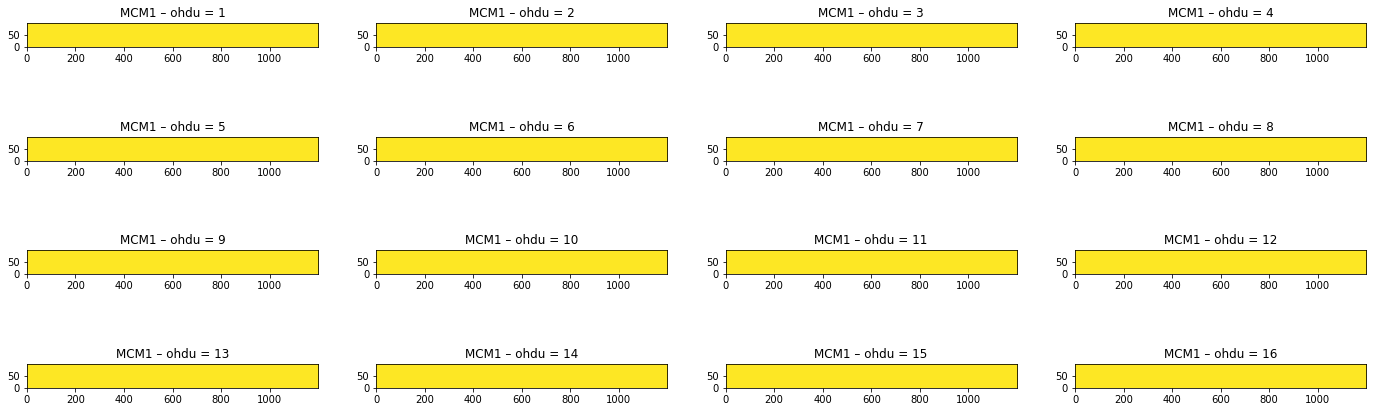

In [ ]:
imName='MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP1_18.fits'
image_hdu=fits.open(imName)

plt.figure(figsize=(24,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_hdu[i+1].data, vmin=-500, vmax=500)    #Plot de cada imagen en un rango de -500 a 500 ADUS
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))

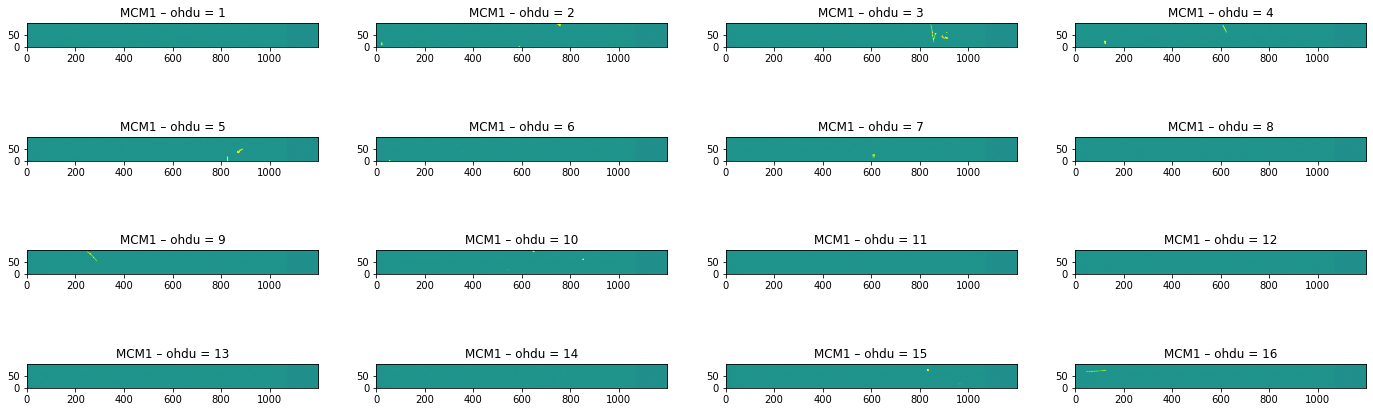

In [ ]:
for i in range(nCCDs):      #el valor de la imagen sera el de la imagen cruda menos la mediana
    image_hdu[i+1].data = hm[i+1].data.astype('float64') - np.median(hm[i+1].data[overscan_mask], axis=1, keepdims=True)

plt.figure(figsize=(24,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_hdu[i+1].data[:,:], vmin=-500, vmax=500)    #Plot de cada imagen en un rango de -500 a 500 ADUS
    plt.title('MCM1 – ohdu = {:d}'.format(i+1))



/tmp/ipykernel_3535/1508123804.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)


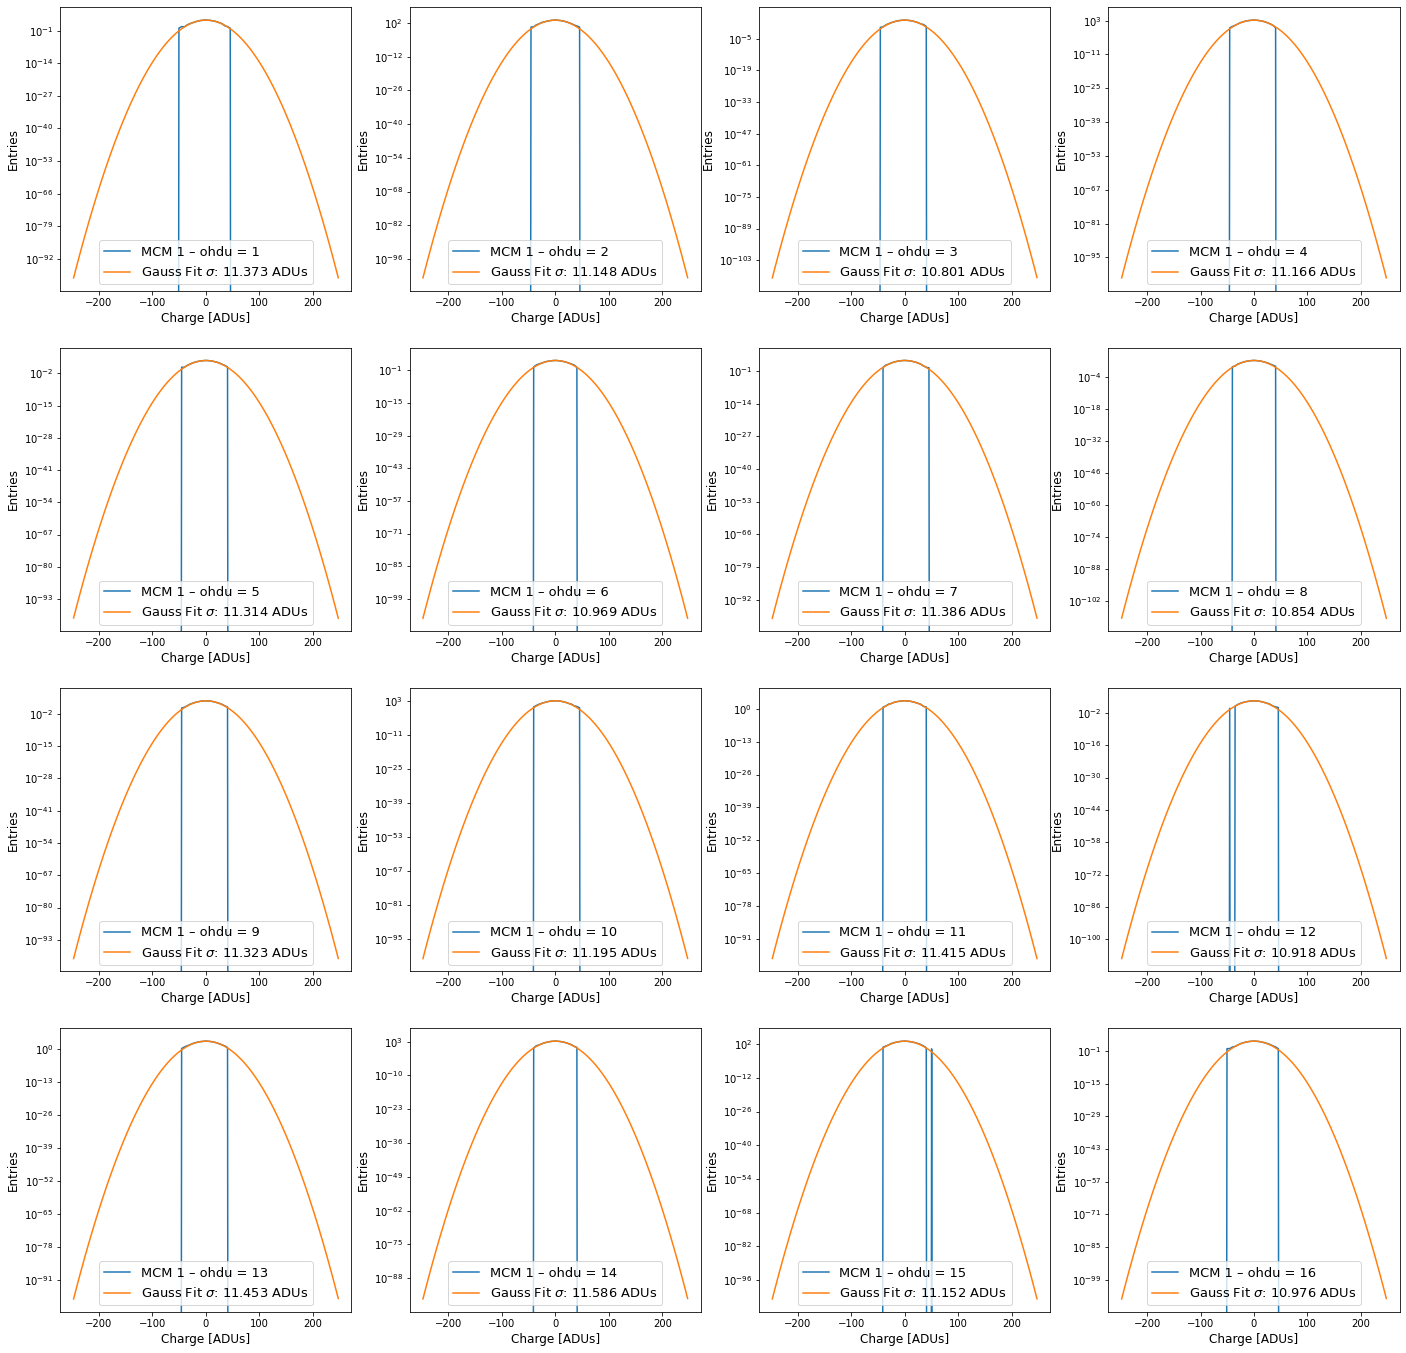

In [ ]:
noise = Noise(image_hdu, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot=True, pdfname='None.pdf')

In [ ]:
ohdusOK

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
path_files='/home/mauricio/datosFits/mcm_data/ansamp'
listFiles=os. listdir(path_files) 
numberList = []
dict_list = {}
noise_list = []
for i in listFiles:
    dict_list[(i.split('_')[-1]).split('.')[0]]=i

order2process=sorted(dict_list)

for i in order2process:
    fileName=dict_list[i].split('.')[0]
    MCMNro=1
    outname='MCM'+str(MCMNro)+'_Demuxed_'+re.sub(".fz","",fileName)+'.fits';
    step=16
    #Get 16-demuxed Images from the MCM
    #Primary HDU no data, only main header
    Primaryhdu_MCM = fits.PrimaryHDU() # Create primary HDU without data
    hdu_list_MCM = fits.HDUList([Primaryhdu_MCM]) #Create HDU list
    hdu_list_MCM[0].header=h[0].header
    for i in range(0,16):
        MapMCM_ColInit=MappingToMux[MappingToOHDUinfits[i]-1]  #REVISAR ACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAaaa!
        datai=np.int32(GetSingleCCDImage(h,hduUse,MapMCM_ColInit,NCOL,step,1))
        #print(datai.dtype)
        image_hdu=fits.ImageHDU(datai);
        image_hdu.header=h[hduUse].header #Repear the header of the used hdu channel into all the 16-channles
        image_hdu.header.set('NSAMP',ANSAMP)
        hdu_list_MCM.append(image_hdu)

    fileHeader=open('fileHeader.txt', 'w')
    fileHeader.write(repr(h[1].header))
    fileHeader.close()

    hdu_list_MCM.writeto(outname,overwrite=True)
    hdu_list_MCM.close()
    
    noise_list.append(Noise(hdu_list_MCM, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot=False, pdfname='None.pdf'))
    

/tmp/ipykernel_3535/1508123804.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)
/home/mauricio/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_3535/1508123804.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


In [ ]:
file_FITS=file_FITS=fits.open('/home/oem/Software/cursoInstrumentacion_2022/ClasesPy/60 - MCM Test/MCM1_Demuxed_barrido_ANSAMP_exp_1s_ignorando_2muestras_ANSAMP400_27.fits')

In [ ]:
Noise(file_FITS, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot=False, pdfname='None.pdf')

/tmp/ipykernel_31635/1254288085.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


[100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892,
 100.00000000513892]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


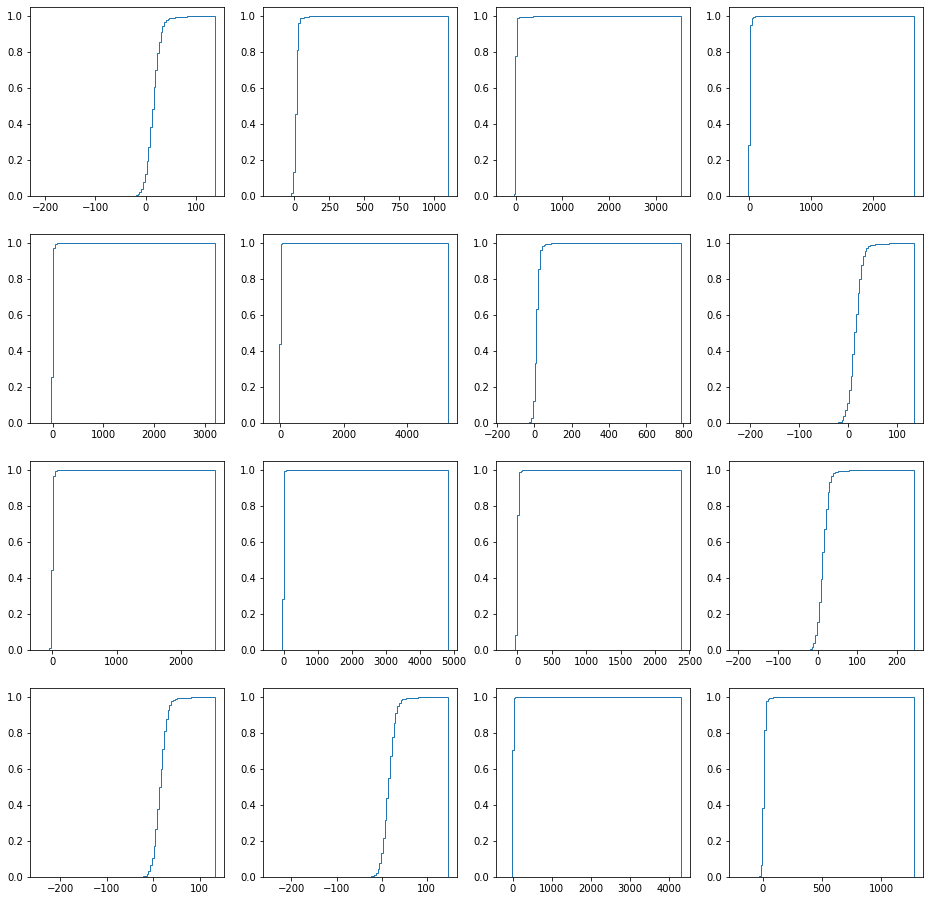

In [ ]:
ohdusOK = np.zeros((16,), dtype=int)
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    y, x, _ = plt.hist(hmb[i+1].data[active_mask].flatten(),100,density=True, histtype='step', cumulative=True)
    #print(i,x.max())
    if x.max()>100: ohdusOK[i]=1
print(ohdusOK)

In [ ]:
def NoiseBkp(h, overscan_mask, iMCM, nCCDs, dataOK, doPlot, pdfname):
    noise = []
    plt.figure(figsize=(24,24))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title("MCM {:d}".format(iMCM), fontsize=18)
    for i in range(nCCDs):
        if dataOK[i]:
            plt.subplot(4,4,i+1)
            y,xb=np.histogram(h[i+1].data[overscan_mask].flatten(), bins=np.linspace(-250,250,200))
            x=(xb[1:]+xb[:-1])/2
            plt.plot(x,y,label='MCM {:d} – ohdu = {:d}'.format(iMCM,i+1))
            # gaussian fit
            try:
                popt,pcov=curve_fit(gaussian1,x,y,p0=[-10,100,10000])
                plt.plot(x,gaussian1(x,*popt),label="Gauss Fit $\sigma$: {:.3f} ADUs".format(popt[1]))
                noise.append(popt[1])
            except RuntimeError:
                print("Error - gain fit failed" + pdfname)
                noise.append(-1)
            plt.legend(fontsize=13)
            plt.xlabel("Charge [ADUs]",fontsize=12)
            plt.yscale("log")
            plt.ylabel("Entries",fontsize=12)
        else: noise.append(-1)
    # to save the plot
    #pdf_filename = f'noise_'+pdfname+'_{iMCM+1}.pdf'i
    if doPlot:
        # pdf_filename = f'noise_{pdfname}.pdf'
        # plt.savefig(pdf_filename, format='pdf')
        plt.show()
    plt.close()
    return noise

/tmp/ipykernel_4312/2956685803.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)


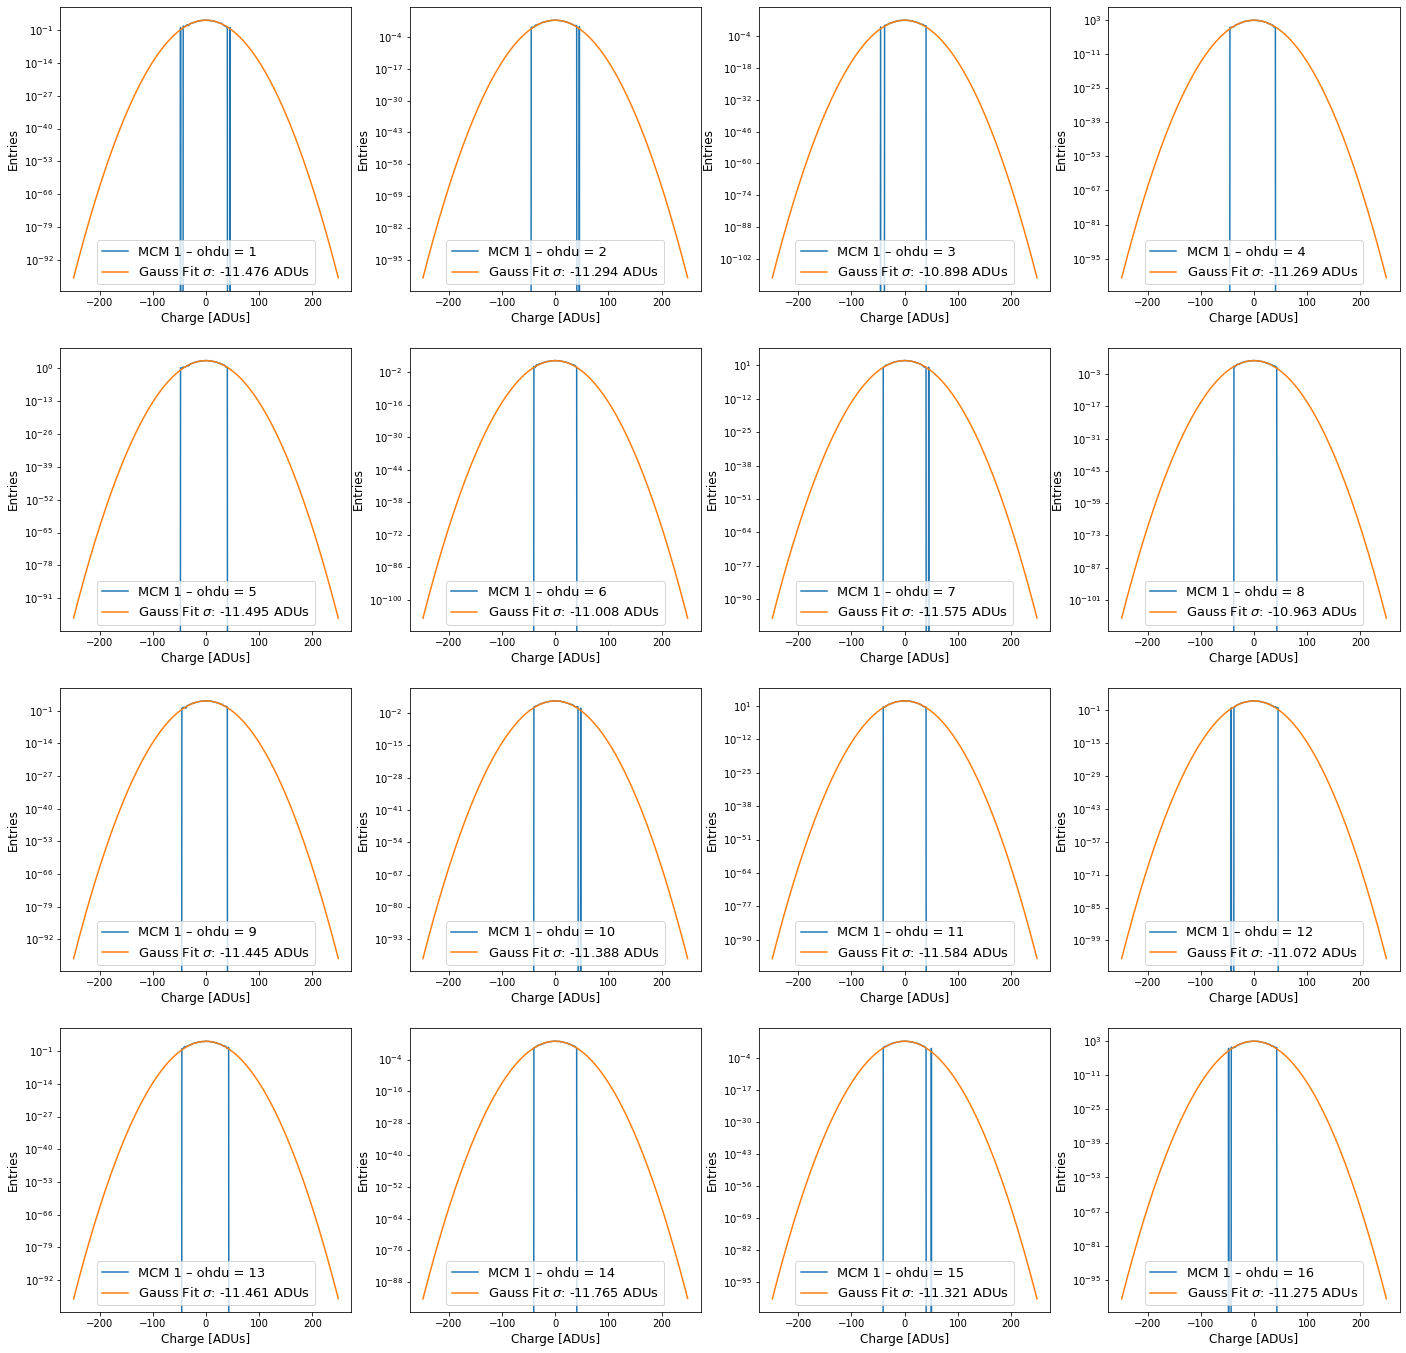

In [ ]:
noise = NoiseBkp(hmb, overscan_mask, MCMNro, nCCDs, ohdusOK, doPlot, pdfname)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   4.,   0.,   2.,   4.,  13.,
          3.,  13.,  27.,  42.,  49.,  75.,  84., 132., 203., 240., 297.,
        392., 492., 512., 521., 623., 604., 696., 597., 568., 501., 438.,
        404., 374., 283., 213., 194., 126.,  83.,  63.,  54.,  41.,  16.,
          7.,   4.,   0.,   4.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-100.,  -98.,  -96.,  -94.,  -92.,  -90.,  -88.,  -86.,  -84.,
         -82.,  -80.,  -78.,  -76.,  -74.,  -72.,  -70.,  -68.,  -66.,
         -64.,  -62.,  -60.,  -58.,  -56.,  -54.,  -52.,  -50.,  -48.,
         -46.,  -44.,  -42.,  -40.,  -38.,  -36.,  -34.,  -32.,  -30.,
         -28.,  -26.,  -24.,  -22.